In [1]:
# Model
from src.model import UNet

# Dataset
from src.dataset import SatelliteRoadDataset

# Runners
from src.runners import train, validate

# Utils
from src.utils import reproject_landsat_image, compute_class_weights

# Numpy
import numpy as np

# Pandas
import geopandas as gpd

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# Sklearn
from sklearn.model_selection import train_test_split

# Matplotlib
import matplotlib.pyplot as plt

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
# Load the roads data
roads_data = gpd.read_file('data/ghana-231113-highway.geojson')

# Filter out non-LineString geometries
roads_data = roads_data[roads_data.geometry.type == 'LineString']

# Reproject to Web Mercator (EPSG: 3395)
roads_data = roads_data.to_crs(epsg=3395)

In [4]:
# Landsat images paths
landsat_directory = 'data/tamale_landsat/'
images_name_prefix = 'LC09_L2SP_194053_20231024_20231025_02_T1_SR_B'

# Create a list of the paths to the images to reproject
images_to_process_paths = [landsat_directory + images_name_prefix + str(i) + '.TIF' for i in range(1, 8)]

In [5]:
# Process each of the landsat images
for image_path in images_to_process_paths:
    reproject_landsat_image(image_path, image_path.replace('.TIF', '_reprojected.TIF'))

# Create a list of the paths to the reprojected images
images_paths = [landsat_directory + images_name_prefix + str(i) + '_reprojected.TIF' for i in range(1, 8)]

Number of patches: 702


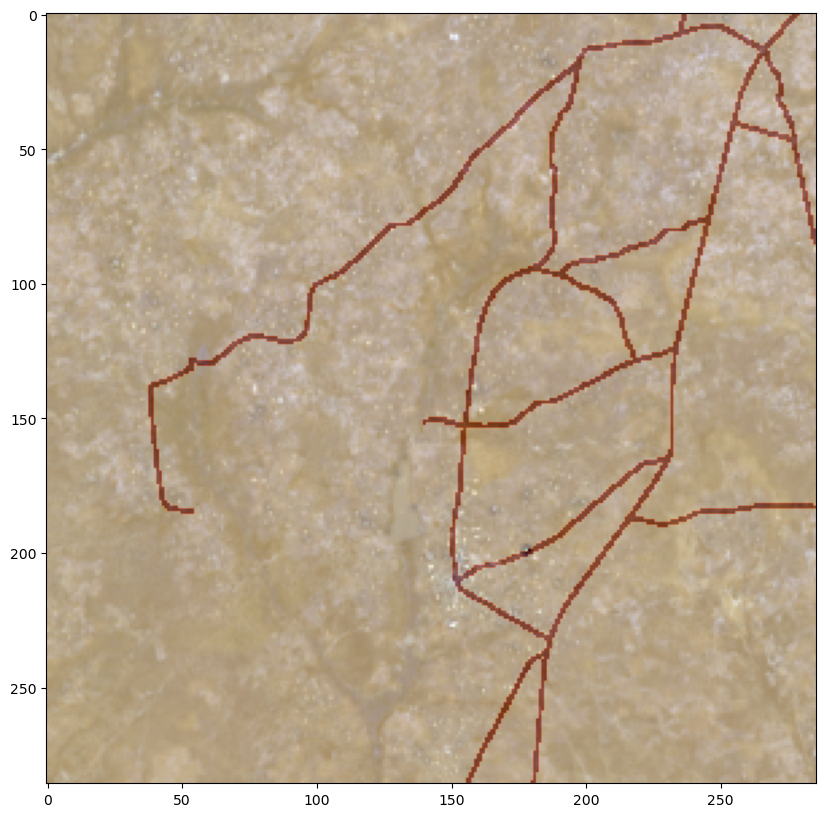

Shape of satellite image: torch.Size([7, 286, 286])
Shape of label: torch.Size([286, 286])


In [6]:
# Test the dataset
dataset = SatelliteRoadDataset(roads_data, images_paths, patch_size=286, rotation=None, stretch_factor=None, buffer_size=10)
print('Number of patches:', len(dataset))

# Plot one patch with label mask overlay
patch_idx = 148
bands = np.stack([dataset[patch_idx][0][i, :, :] for i in range(3)], axis=-1)
label_mask = dataset[patch_idx][1]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(bands)
ax.imshow(label_mask, cmap='Reds', alpha=0.4)
plt.show()

print('Shape of satellite image:', dataset[patch_idx][0].shape)
print('Shape of label:', label_mask.shape)

In [7]:
# Compute the class weights
pos_weight = compute_class_weights(dataset)
print('Class weights:', pos_weight)

Class weights: tensor([42.9894])


In [8]:
# Parameters
epochs = 10
optimizer_kwargs = {
    'lr': 1e-4,
    'weight_decay': 1e-4
}

# Load the model
model = UNet(batch_norm=True)

# Move the model to GPU if available
if (torch.cuda.is_available()):
    device = torch.device('cuda');
elif (torch.backends.mps.is_available()):
    device = torch.device('mps');
else:
    device = torch.device('cpu');
model.to(device)

# Create the datasets
dataset = SatelliteRoadDataset(roads_data, images_paths, patch_size=286, buffer_size=10)
rotated_dataset = SatelliteRoadDataset(roads_data, images_paths, patch_size=286, rotation=True, buffer_size=10)
stretched_dataset = SatelliteRoadDataset(roads_data, images_paths, patch_size=286, stretch_factor=1.3, buffer_size=10)

# Splitting dataset into training and validation sets
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
rotated_train_dataset = Subset(rotated_dataset, train_indices)
stretched_train_dataset = Subset(stretched_dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
rotated_train_dataloader = DataLoader(rotated_train_dataset, batch_size=4, shuffle=True)
stretched_train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# Fix the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Loss function (binary cross entropy)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=(pos_weight/4).to(device))

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), **optimizer_kwargs)

In [9]:
# Training and validation Loop
best_loss = float('inf')
best_f1 = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    if t%2 == 1 and t<=epochs/2:
        train_loss, train_f1 = train(rotated_train_dataloader, model, loss_fn, optimizer, device, t, writer)
        val_loss, val_f1 = validate(val_dataloader, model, loss_fn, device, t, writer)
    
    elif t%2 == 0 and t<= epochs/2:
        train_loss, train_f1 = train(stretched_train_dataloader, model, loss_fn, optimizer, device, t, writer)
        val_loss, val_f1 = validate(val_dataloader, model, loss_fn, device, t, writer)
    
    else:
        train_loss, train_f1 = train(train_dataloader, model, loss_fn, optimizer, device, t, writer)
        val_loss, val_f1 = validate(val_dataloader, model, loss_fn, device, t, writer)
    
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}")

    # Save the best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_unet_model.pth')
        print("Saved the Best Model!")

writer.flush()

Epoch 1
-------------------------------
Training Loss: 0.6611, Validation Loss: 0.5943
Training F1: 0.1084, Validation F1: 0.2387
Saved the Best Model!
Epoch 2
-------------------------------
Training Loss: 0.6011, Validation Loss: 0.5792
Training F1: 0.1185, Validation F1: 0.2185
Epoch 3
-------------------------------
Training Loss: 0.5764, Validation Loss: 0.5730
Training F1: 0.1077, Validation F1: 0.1450
Epoch 4
-------------------------------
Training Loss: 0.5510, Validation Loss: 0.5448
Training F1: 0.1425, Validation F1: 0.1803
Epoch 5
-------------------------------
Training Loss: 0.5559, Validation Loss: 0.5531
Training F1: 0.1305, Validation F1: 0.1675
Epoch 6
-------------------------------
Training Loss: 0.5410, Validation Loss: 0.5344
Training F1: 0.1458, Validation F1: 0.1574
Epoch 7
-------------------------------
Training Loss: 0.5436, Validation Loss: 0.9970
Training F1: 0.1375, Validation F1: 0.0547
Epoch 8
-------------------------------
Training Loss: 0.5382, Valid

(81796,)
[0. 1.]


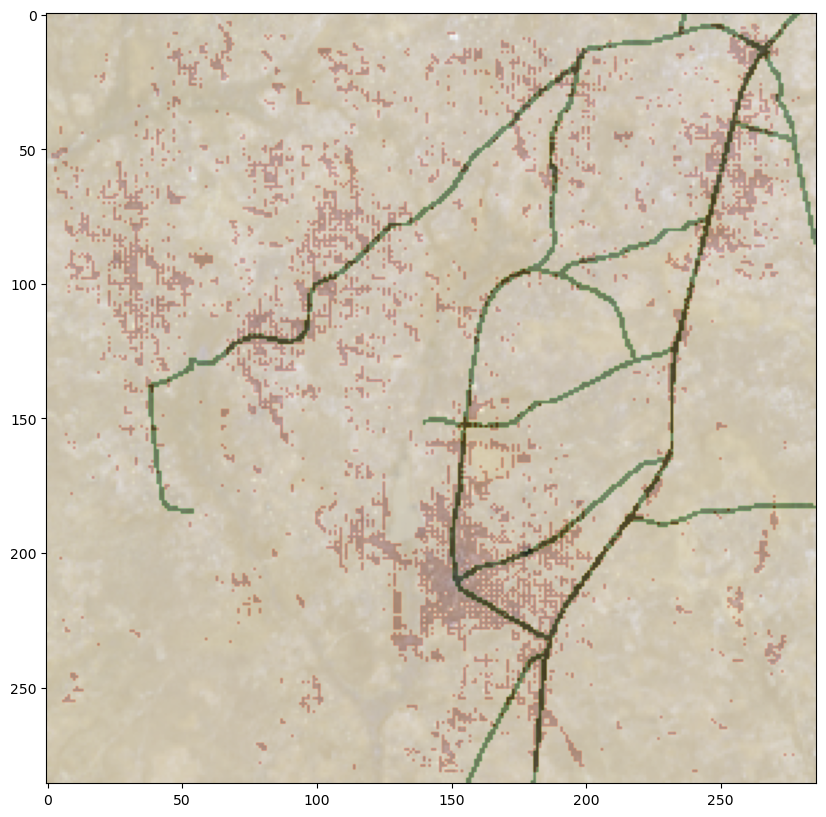

In [10]:
# Get a prediction for a patch
patch_idx = 148
patch = dataset[patch_idx][0].unsqueeze(0).to(device)
pred = model(patch)
pred = torch.round(torch.sigmoid(pred)).view(-1).cpu().detach().numpy()
print(pred.shape)
print(np.unique(pred))

label_mask = dataset[patch_idx][1]

# Plot the prediction
fig, ax = plt.subplots(figsize=(10, 10))
bands = np.stack([dataset[patch_idx][0][i, :, :] for i in range(3)], axis=-1)
ax.imshow(bands)
ax.imshow(pred.reshape(286, 286), cmap='Reds', alpha=0.4)
ax.imshow(label_mask, cmap='Greens', alpha=0.4)
plt.show()